In [ ]:

from sklearn import datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_splitimport cvxpy as cp
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.svm import SVC


In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X = X[:, [0,3]]
y[y == 2] = 1

In [ ]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [ ]:
def train_hard_margin_svm(X, y):
    num_samples, num_features = X.shape
    weight_vector = cp.Variable((num_features, 1))
    bias = cp.Variable()
    constraints = [cp.multiply(y, (X @ weight_vector + bias)) >= 1]
    objective = cp.Minimize(cp.norm(weight_vector, 2))
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return weight_vector.value, bias.value

In [ ]:
def one_vs_all_train(data_matrix, target_labels):
    num_classes = len(np.unique(target_labels))
    classifiers = []

    for i in range(num_classes):
        binary_labels = np.where(target_labels == i, 1, -1).reshape(-1, 1)
        weight_vector, bias = train_hard_margin_svm(data_matrix, binary_labels)
        classifiers.append((weight_vector, bias))

    return classifiers

classifiers = one_vs_all_train(X_normalized, y)

In [ ]:
def predict_one_vs_all(data_matrix, all_models):
    predictions = []

    for sample in data_matrix:
        scores = []
        for model_weights, model_bias in all_models:
            if model_weights is None:
                continue
            score = np.dot(sample, model_weights.flatten()) + model_bias
            scores.append(score)

        predicted_class = np.argmax(scores)
        predictions.append(predicted_class)

    return np.array(predictions)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
y_pred = predict_one_vs_all(X_test, classifiers)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 1.0


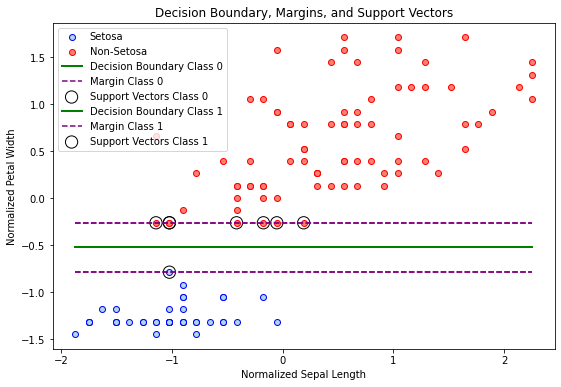

In [ ]:
def visualize_decision_boundary(features, target_values, decision_models):
    plt.figure(figsize=(9, 6))

    class_1_data = features[target_values == 0]
    class_2_data = features[target_values != 0]

    plt.scatter(class_1_data[:, 0], class_1_data[:, 1], edgecolor='blue', label='Setosa', color='lightblue')
    plt.scatter(class_2_data[:, 0], class_2_data[:, 1], edgecolor='red', label='Non-Setosa', color='salmon')

    for i, (model_weights, model_bias) in enumerate(decision_models):
        if model_weights is None:
            continue
        slope = -model_weights[0] / model_weights[1]
        intercept = -model_bias / model_weights[1]

        margin = 1 / np.sqrt(np.sum(model_weights**2))

        x_decision_range = np.linspace(np.min(features[:, 0]), np.max(features[:, 0]), 100)
        y_decision = slope * x_decision_range + intercept

        plt.plot(x_decision_range, y_decision, color='green', linestyle='-', linewidth=2, label=f'Decision Boundary Class {i}')

        y_margin_upper = slope * x_decision_range + (intercept + margin)
        y_margin_lower = slope * x_decision_range + (intercept - margin)

        plt.plot(x_decision_range, y_margin_upper, color='purple', linestyle='--', linewidth=1.5, label=f'Margin Class {i}')
        plt.plot(x_decision_range, y_margin_lower, color='purple', linestyle='--', linewidth=1.5)

        support_vectors = np.where(np.abs(features @ model_weights + model_bias - 1) <= 1e-4)[0]

        plt.scatter(features[support_vectors, 0], features[support_vectors, 1], s=150, marker='o', facecolors='none', edgecolors='black', label=f'Support Vectors Class {i}')

    plt.xlabel('Normalized Sepal Length')
    plt.ylabel('Normalized Petal Width')
    plt.title('Decision Boundary, Margins, and Support Vectors')
    plt.legend()
    plt.show()

visualize_decision_boundary(X_train[:, :2], y_train, classifiers)

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[:, [0,1]]
y[y == 2] = 1

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

def train_soft_margin_svm(X, y, C):
    num_samples, num_features = X.shape
    w = cp.Variable((num_features, 1))
    b = cp.Variable()
    slack_vars = cp.Variable((num_samples, 1))
    constraints = [cp.multiply(y, (X @ w + b)) >= 1 - slack_vars, slack_vars >= 0]
    objective = cp.Minimize(cp.norm(w, 2) + C * cp.sum(slack_vars))
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value, b.value


def one_vs_all_train(X, y, C):
    num_classes = len(np.unique(y))
    classifiers = []

    for i in range(num_classes):
        y_binary = np.where(y == i, 1, -1).reshape(-1, 1)
        w, b = train_soft_margin_svm(X, y_binary, C)
        classifiers.append((w, b))

    return classifiers

C = 1.0
classifiers = one_vs_all_train(X_normalized, y, C)

def predict_one_vs_all(X, classifiers):
    predictions = []

    for sample in X:
        scores = []
        for w, b in classifiers:
            if w is None:
                break
            score = np.dot(sample, w.flatten()) + b
            scores.append(score)

        predicted_class = np.argmax(scores)
        predictions.append(predicted_class)

    return np.array(predictions)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
y_pred = predict_one_vs_all(X_test, classifiers)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 1.0


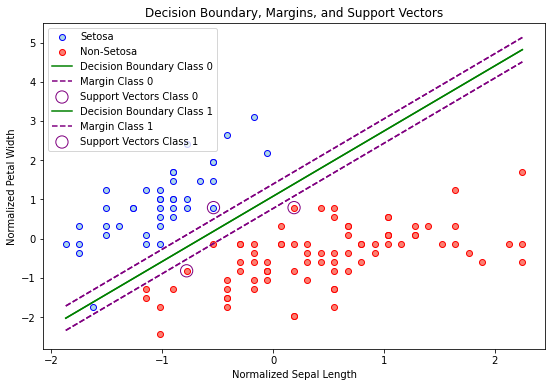

In [ ]:
def plot_decision_boundary(X, y, classifiers):

    plt.figure(figsize=(9, 6))

    s1 = np.where(y == 0)
    s2 = np.where(y != 0)

    plt.scatter(X[s1, 0], X[s1, 1], color='lightblue', edgecolor='blue', label='Setosa')
    plt.scatter(X[s2, 0], X[s2, 1], color='salmon', edgecolor='red', label='Non-Setosa')


    for i, (w, b) in enumerate(classifiers):
        slope = -w[0] / w[1]
        intercept = -b / w[1]
        margin = 1 / np.sqrt(np.sum(w**2))

        x_decision = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
        y_decision = slope * x_decision + intercept
        plt.plot(x_decision, y_decision, color='green', linestyle='-', label=f'Decision Boundary Class {i}')

        y_margin_1 = slope * x_decision + (intercept - margin)
        y_margin_2 = slope * x_decision + (intercept + margin)
        plt.plot(x_decision, y_margin_1, color='purple', linestyle='--', label=f'Margin Class {i}')
        plt.plot(x_decision, y_margin_2, color='purple', linestyle='--')

        support_vectors = np.where(np.abs(X @ w + b - 1) <= 1e-4)[0]
        plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=150, facecolors='none', edgecolors='purple', label=f'Support Vectors Class {i}')

    plt.xlabel('Normalized Sepal Length')
    plt.ylabel('Normalized Petal Width')
    plt.title('Decision Boundary, Margins, and Support Vectors')
    plt.legend()
    plt.show()

plot_decision_boundary(X_train[:, :2], y_train, classifiers)

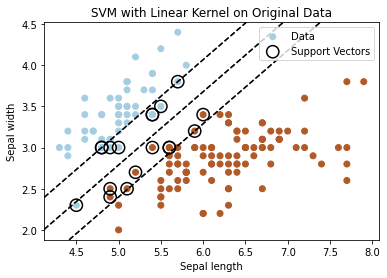

In [ ]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 2 - 1

def plot_decision_boundary(clf, X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, label='Data')
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Grid Creation
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='black', levels=[-1, 0, 1], alpha=1, linestyles='--')
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles='--')

    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=150, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.title('SVM with Linear Kernel on Original Data')
    plt.legend()
    plt.show()

clf = SVC(kernel='linear')
clf.fit(X, y)
plot_decision_boundary(clf, X, y)

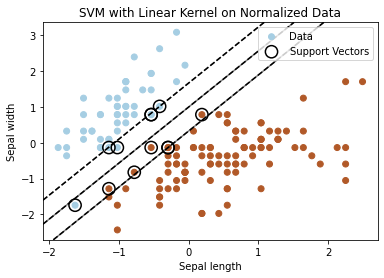

In [ ]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

clf_normalized = make_pipeline(StandardScaler(), SVC(kernel='linear'))
clf_normalized.fit(X_normalized, y)

def plot_decision_boundary(clf, X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, label='Data')
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='black', levels=[-1, 0, 1], alpha=1, linestyles='--')
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5)

    if isinstance(clf[-1], SVC):
        ax.scatter(clf[-1].support_vectors_[:, 0], clf[-1].support_vectors_[:, 1],
                    s=150, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.title('SVM with Linear Kernel on Normalized Data')
    plt.legend()
    plt.show()

plot_decision_boundary(clf_normalized, X_normalized, y)

Hard-Margin SVM converged successfully.


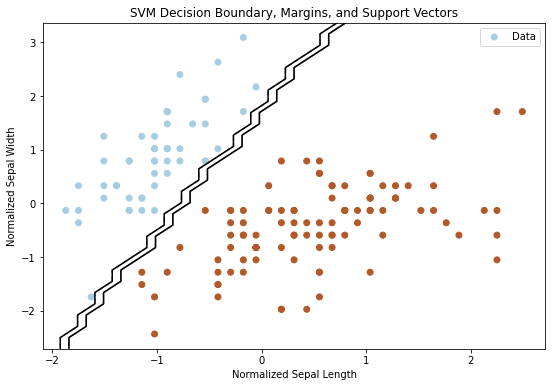

Soft-Margin SVM converged successfully.


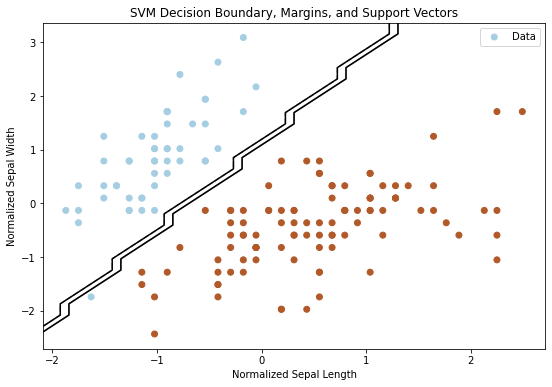

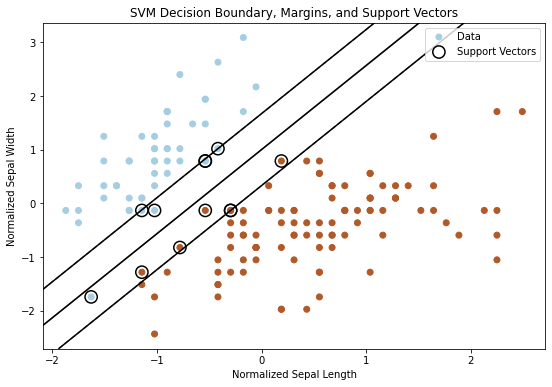

In [ ]:
iris = datasets.load_iris()
X = iris.data[:, [0, 1]]
y = (iris.target != 0) * 2 - 1

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

def plot_decision_boundary(clf, X, y):
    plt.figure(figsize=(9, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, label='Data')
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(xy).reshape(XX.shape)
    else:
        Z = clf(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='black', levels=[-1, 0, 1], alpha=1, linestyles=['-', '-', '-'])
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    if isinstance(clf, SVC):
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                   s=150, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

    plt.xlabel('Normalized Sepal Length')
    plt.ylabel('Normalized Sepal Width')
    plt.title('SVM Decision Boundary, Margins, and Support Vectors')
    plt.legend()
    plt.show()

def train_hard_margin_svm(X, y):
    num_samples, num_features = X.shape
    w = None
    b = None

    if len(np.unique(y)) < 2:
        print("Error: At least one sample per class is required.")
        return w, b

    weight_vector = cp.Variable((num_features, 1))
    bias = cp.Variable()
    constraints = [cp.multiply(y, (X @ weight_vector + bias)) >= 1]
    objective = cp.Minimize(cp.norm(weight_vector, 2))
    prob = cp.Problem(objective, constraints)
    prob.solve()

    if prob.status == cp.OPTIMAL:
        w = weight_vector.value
        b = bias.value
        print("Hard-Margin SVM converged successfully.")
    else:
        print("Hard-Margin SVM did not converge.")

    return w, b

w_linear_hm, b_linear_hm = train_hard_margin_svm(X_normalized, y.reshape(-1, 1))
if w_linear_hm is not None:
    clf_linear_hm = lambda x: np.sign(np.dot(x, w_linear_hm) + b_linear_hm)
    plot_decision_boundary(clf_linear_hm, X_normalized, y)

def train_soft_margin_svm(X, y, C):
    num_samples, num_features = X.shape
    w = None
    b = None

    if len(np.unique(y)) < 2:
        print("Error: At least one sample per class is required.")
        return w, b

    weight_vector = cp.Variable((num_features, 1))
    bias = cp.Variable()
    slack_vars = cp.Variable((num_samples, 1))
    constraints = [cp.multiply(y, (X @ weight_vector + bias)) >= 1 - slack_vars, slack_vars >= 0]
    objective = cp.Minimize(cp.norm(weight_vector, 2) + C * cp.sum(slack_vars))
    prob = cp.Problem(objective, constraints)
    prob.solve()

    if prob.status == cp.OPTIMAL:
        w = weight_vector.value
        b = bias.value
        print("Soft-Margin SVM converged successfully.")
    else:
        print("Soft-Margin SVM did not converge.")

    return w, b

C_linear_sm = 1.0
w_linear_sm, b_linear_sm = train_soft_margin_svm(X_normalized, y.reshape(-1, 1), C_linear_sm)
if w_linear_sm is not None:
    clf_linear_sm = lambda x: np.sign(np.dot(x, w_linear_sm) + b_linear_sm)
    plot_decision_boundary(clf_linear_sm, X_normalized, y)

clf_linear_sklearn = SVC(kernel='linear')
clf_linear_sklearn.fit(X_normalized, y)
plot_decision_boundary(clf_linear_sklearn, X_normalized, y)